# **Skenario 3 - CNN MobileNetV2**

Skenario 3 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNetV2 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, optimizers

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data():
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Muat data dari file NPZ
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Persiapkan daftar X dan Y
    X = []
    Y = []

    # Buat pemetaan label untuk tiap kelas 
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterasi melalui data yang dimuat
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                # Tambahkan data ke X dan Y tanpa mengubah ukuran
                X.append(original_slice)
                Y.append(label_mapping[label])

    # Konversi daftar ke array NumPy
    X = np.array(X) / 255.0  # Normalisasi
    Y = np.array(Y)

    # Konversi label ke format kategorikal
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

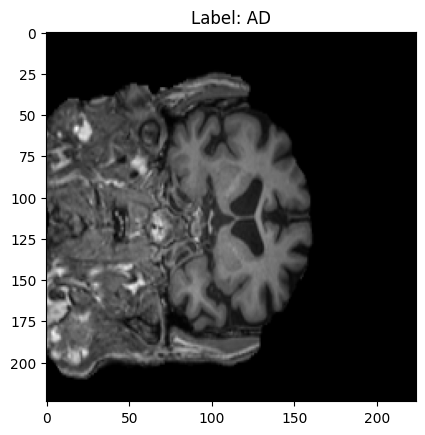

In [ ]:
index_to_visualize = 3
image_to_visualize = X[index_to_visualize]
label_to_visualize = Y[index_to_visualize]

class_names = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI'}
label_to_visualize = class_names[np.argmax(label_to_visualize)]

plt.imshow(image_to_visualize)
plt.title(f"Label: {label_to_visualize}")
plt.imshow(image_to_visualize, cmap='gray')


In [ ]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [ ]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224)
Dimensi Y_test: (1440, 4)


In [ ]:
X_train_rgb = np.expand_dims(X_train, axis=-1)
X_test_rgb = np.expand_dims(X_test, axis=-1)

In [ ]:
X_train_rgb = np.repeat(X_train_rgb, 3, axis=-1)
X_test_rgb = np.repeat(X_test_rgb, 3, axis=-1)

In [ ]:
print("Dimensi X_train_rgb:", X_train_rgb.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test_rgb:", X_test_rgb.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train_rgb: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test_rgb: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


In [ ]:
print("Jumlah sampel dalam X_train:", len(X_train_rgb))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test_rgb))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu MobileNetV2 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [ ]:
%%time
inputs = Input(shape=(224, 224, 3))

# Use MobileNetV2 as a layer in your model
base_model = MobileNetV2(
    weights='imagenet',
    input_tensor=inputs,
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

# Combine input and output to create the model
model = Model(inputs, outputs)

# Set all layers in the base_model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [ ]:
# Fine-tuning
EPOCH = 25
BATCH_SIZE = 16
h_model = model.fit(X_train_rgb, Y_train, epochs=EPOCH, validation_data=(X_test_rgb, Y_test), batch_size=BATCH_SIZE)

Epoch 1/25
 35/360 [=>............................] - ETA: 50s - loss: 2.3659 - accuracy: 0.2298

## 5. Testing

### 5.1 Menilai model pada data uji

In [ ]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test_rgb, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test_rgb)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 16s 343ms/step - loss: 0.8214 - accuracy: 0.7576
Loss: 0.8214018940925598
Accuracy: 0.7576388716697693
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [1 1 2 ... 0 1 1]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

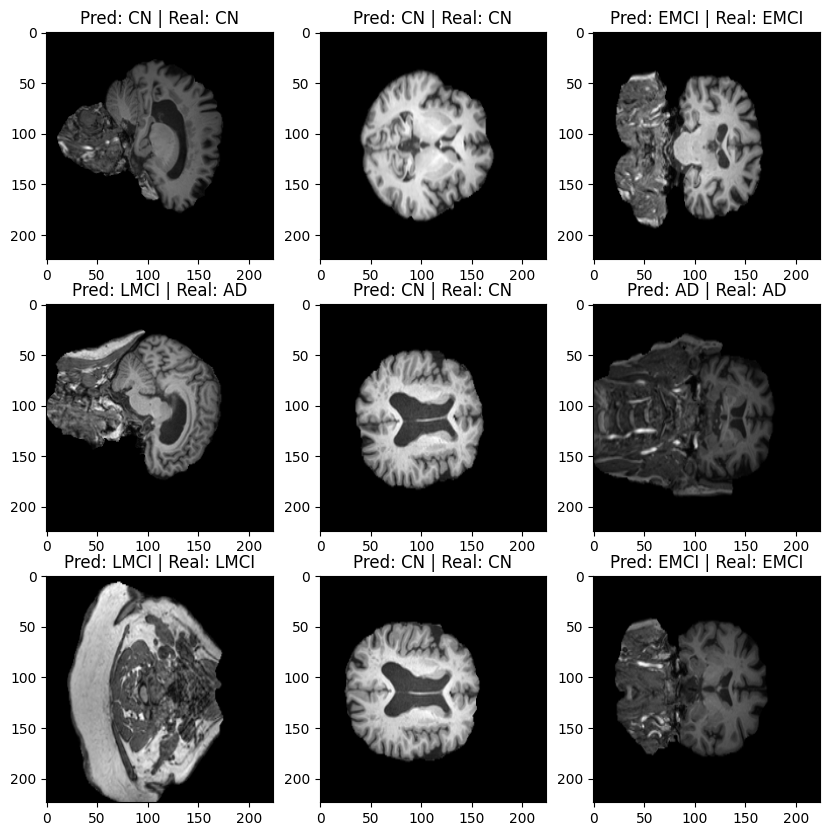

In [ ]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(X_test[i].astype("int64"))
    plt.imshow(X_test[i],cmap="gray")
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [ ]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train

In [ ]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train_rgb, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 62s 341ms/step - loss: 0.1220 - accuracy: 0.9596 - specificity: 0.9884 - sensitivity: 0.9527
Loss train set:  0.12586840987205505
Akurasi train set:  0.9552083611488342
Specificity train set:  0.9873263835906982
Sensitivity train set:  0.9480902552604675


Evaluasi model pada data test

In [ ]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test_rgb, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 16s 343ms/step - loss: 0.8214 - accuracy: 0.7576 - specificity: 0.9273 - sensitivity: 0.7472
Loss train set:  0.8214018940925598
Akurasi train set:  0.7576388716697693
Specificity train set:  0.9273147583007812
Sensitivity train set:  0.7472222447395325


Visualisasi confusion matrix

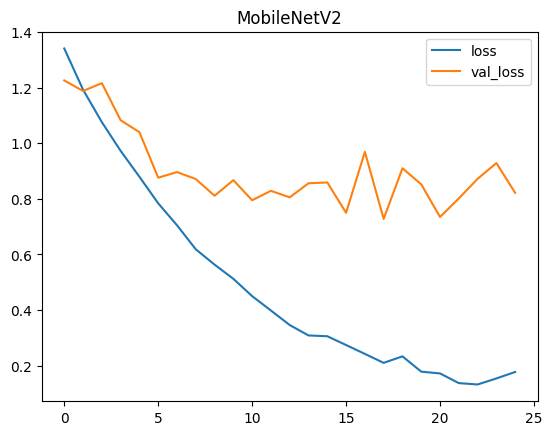

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('MobileNetV2')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\MobileNetV2Loss.png')

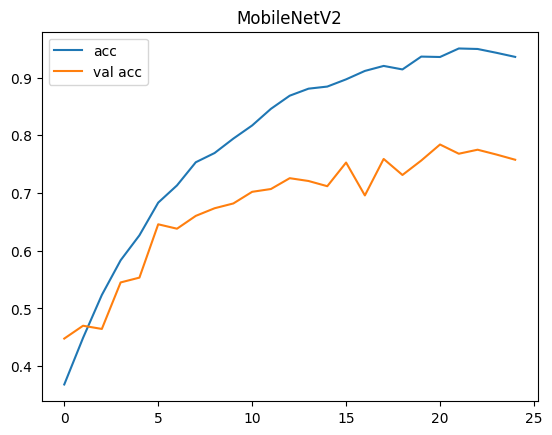

In [ ]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('MobileNetV2')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\MobileNetV2Accuracy.png')

In [ ]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\MobileNetV2.h5")

In [ ]:
y_preds =  model.predict(X_test_rgb)
y_preds

array([[9.9085324e-02, 8.5419738e-01, 4.6699122e-02, 1.8091143e-05],
       [3.9534163e-05, 9.9808156e-01, 1.8782839e-03, 7.2219291e-07],
       [7.6421252e-09, 3.4138463e-06, 9.9999654e-01, 3.8665981e-08],
       ...,
       [9.8679346e-01, 1.5747324e-05, 2.9162779e-08, 1.3190721e-02],
       [2.8678362e-05, 9.9964440e-01, 1.9549399e-08, 3.2685490e-04],
       [2.5860119e-05, 8.1160718e-01, 1.5137864e-04, 1.8821560e-01]],
      dtype=float32)

In [ ]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([1, 1, 2, ..., 0, 1, 1], dtype=int64)

In [ ]:
qwe=np.argmax(Y_test, axis=1)

In [ ]:
confusion_matrix(qwe,y_preds_ind)

array([[277,  53,  15,  35],
       [ 12, 285,  19,  22],
       [ 21,  40, 259,  43],
       [ 17,  44,  28, 270]], dtype=int64)

In [ ]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.85      0.73      0.78       380
           1       0.68      0.84      0.75       338
           2       0.81      0.71      0.76       363
           3       0.73      0.75      0.74       359

    accuracy                           0.76      1440
   macro avg       0.76      0.76      0.76      1440
weighted avg       0.77      0.76      0.76      1440



In [ ]:
model.evaluate(X_test_rgb, Y_test)

45/45 [==============================] - 16s 353ms/step - loss: 0.8214 - accuracy: 0.7576 - specificity: 0.9273 - sensitivity: 0.7472


[0.8214018940925598,
 0.7576388716697693,
 0.9273147583007812,
 0.7472222447395325]

### 6.3 ROC AUC Curve

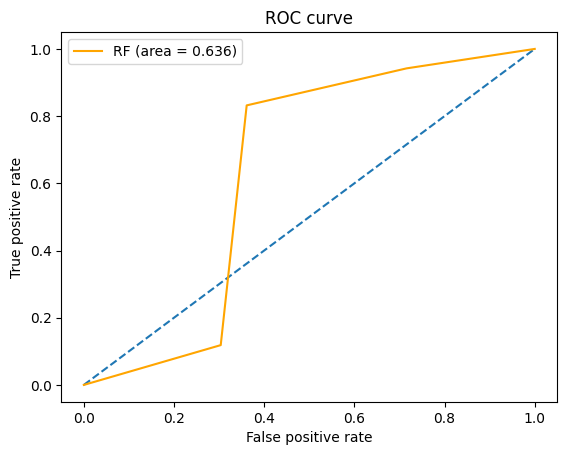

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Visualization

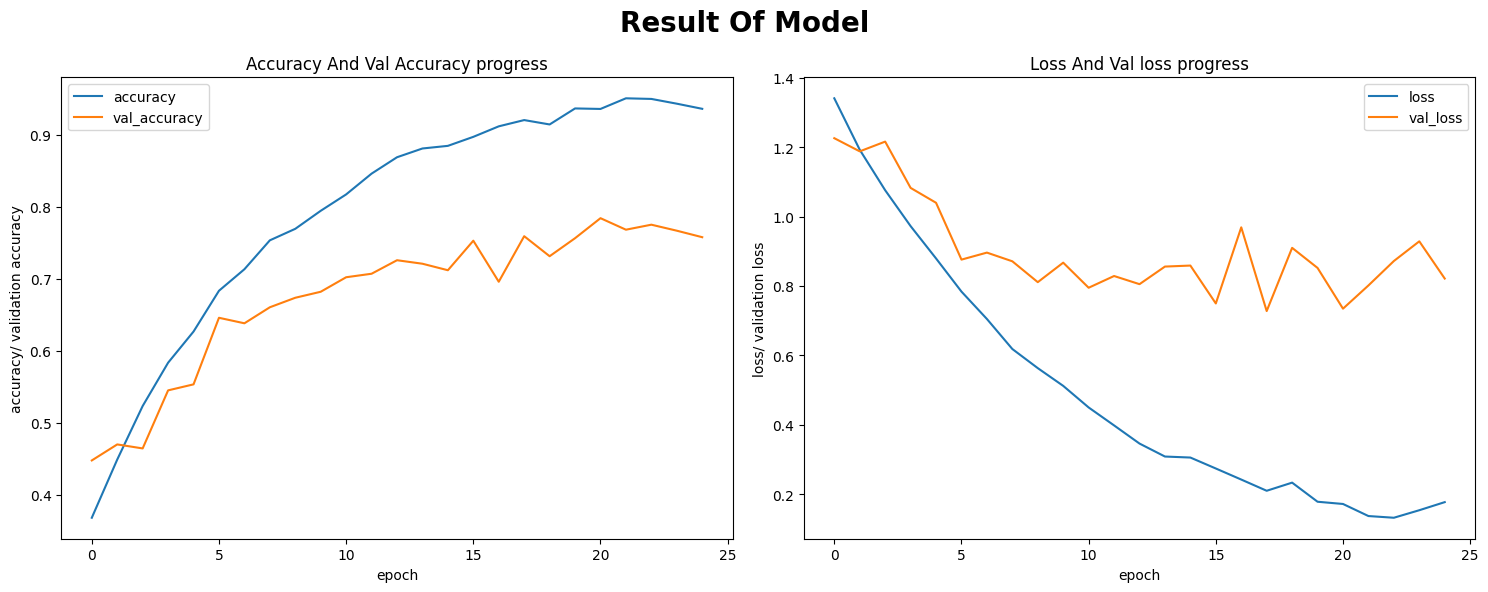

In [ ]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_Loss_figure_ResNet50.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross Validation

In [ ]:
# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Tentukan model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_MobileNetV2.h5', verbose=1, save_best_only=True)

# Tentukan fungsi untuk fit model
def fit_and_evaluate(X_train_rgb, X_test_rgb, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=16, model=model):
    results = model.fit(X_train_rgb, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test_rgb, Y_test))
    return results

### 7.1 Training

In [ ]:
n_folds = 5
epochs = 20
batch_size = 16

# Simpan riwayat model
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                        random_state=np.random.randint(1, 1000, 1)[0])
    
    model_history.append(fit_and_evaluate(X_train_rgb, X_test_rgb, Y_train, Y_test, epochs, batch_size))
    
    # Pembersihan manual
    gc.collect()
    
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20


ValueError: in user code:

    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer Conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (16, 224, 224)


### 7.2 Evaluasi Cross - Validation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


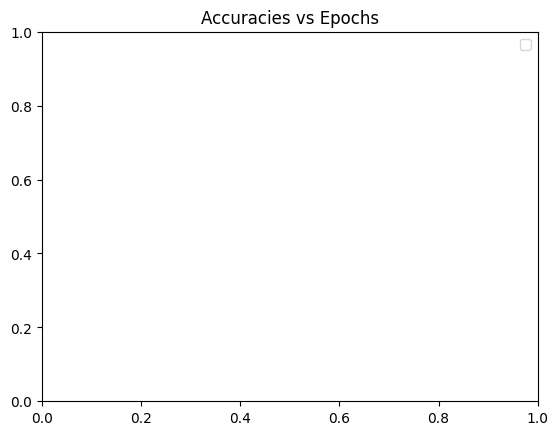

In [ ]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_vs_Epoch_MobileNetV2.png')

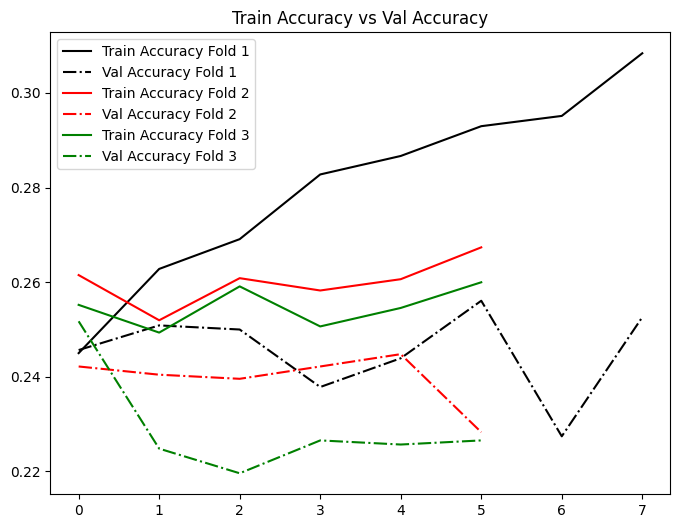

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\TrainAccuracy_vs_ValAccuracy_MobileNetV2.png')

In [ ]:
y_preds =  model.predict(X_test_rgb)
y_preds

array([[0.2515056 , 0.25279674, 0.24581009, 0.24988763],
       [0.2515056 , 0.25279674, 0.24581009, 0.24988763],
       [0.2515056 , 0.25279674, 0.24581009, 0.24988763],
       ...,
       [0.2515056 , 0.25279674, 0.24581009, 0.24988763],
       [0.2515056 , 0.25279674, 0.24581009, 0.24988763],
       [0.2515056 , 0.25279674, 0.24581009, 0.24988763]], dtype=float32)

In [ ]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
asd = np.argmax(Y_test, axis=1)
asd

array([1, 3, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
confusion_matrix(asd,y_preds_arg)

array([[  0, 350,   0,   0],
       [  0, 340,   0,   0],
       [  0, 394,   0,   0],
       [  1, 355,   0,   0]], dtype=int64)

In [ ]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       350
           1       0.24      1.00      0.38       340
           2       0.00      0.00      0.00       394
           3       0.00      0.00      0.00       356

    accuracy                           0.24      1440
   macro avg       0.06      0.25      0.10      1440
weighted avg       0.06      0.24      0.09      1440



c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

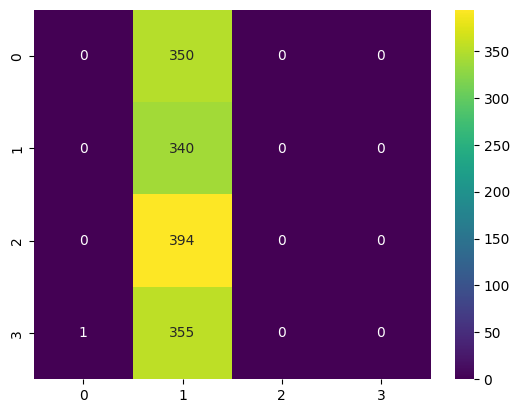

In [ ]:
draw_confusion_matrix(asd,y_preds_arg)